## Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import set_matplotlib_hangul # 한글 폰트 꺠짐 방지
import statsmodels.api as sm
from scipy.stats import pearsonr, f_oneway

Hangul OK in your MAC!


In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

description = pd.read_csv('../data/4. Week/4th_data_description.csv')
source = pd.read_csv('../data/4. Week/4th_data(source).csv')
target = pd.read_csv('../data/4. Week/4th_data(target).csv')

print(f"Description: {description.shape}")
print(f"Source: {source.shape}")
print(f"Target: {target.shape}")
description

Description: (13, 2)
Source: (13262, 12)
Target: (1000, 32)


,task name,Unnamed: 1
0,FirstContact,최초 연락
1,MakeTicket,청구서생성
2,ArrangeSurvey,상담내용정의
3,InformClientSurvey,고객문의전산처리
4,Survey,상담진행
5,InternRepair,단순 수리
6,RepairReady,수리종료
7,SendTicketToFinAdmin,청구서발송 to 관리자
8,ReadyInformClient,고객정보준비
9,TicketReady,청구서송달


## 1.&nbsp; 업무 프로세스 분석

- target 데이터 기반 업무 프로세스

In [3]:
target.head()

,caseID,FirstContact,FirstContact_type,FirstContact_originator,InformClientWrongPlace,InformClientWrongPlace_originator,MakeTicket_start,MakeTicket_end,MakeTicket_originator,MakeTicket_originator:1,...,InternRepair_end_originator,ImmediateRepair_start,ImmediateRepair_start_originator,ImmediateRepair_end,ImmediateRepair_end_originator,ExternRepair,ExternRepair_originator,SendTicketToFinAdmin,ReadyInformClient,TicketReady
0,1,1970-01-02 08:08,Phone,Dian,NaN,NaN,1970-01-02 08:08,1970-01-02 08:11,E,Dian,...,John,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-17 14:03,1970-01-17 15:44,1970-01-17 15:44
1,2,1970-01-08 05:17,Personal,Dian,NaN,NaN,1970-01-08 05:17,1970-01-08 05:21,P,Dian,...,NaN,1970-01-12 04:57,Anne,1970-01-12 06:57,Anne,1970-01-12 06:57,DoIt,1970-01-12 15:14,1970-01-12 11:17,1970-01-12 15:14
2,3,1970-01-03 01:03,Phone,Dian,NaN,NaN,1970-01-03 01:03,1970-01-03 01:10,E,Dian,...,Paul,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-07 06:26,1970-01-07 07:04,1970-01-07 07:04
3,4,1970-01-03 08:23,Personal,Monica,NaN,NaN,1970-01-03 08:23,1970-01-03 08:27,P,Monica,...,NaN,1970-01-04 17:42,Anne,1970-01-04 19:42,Anne,NaN,NaN,1970-01-04 23:35,1970-01-04 20:56,1970-01-04 23:35
4,5,1970-01-07 20:41,Letter,Monica,NaN,NaN,1970-01-07 20:41,1970-01-07 20:47,P,Monica,...,NaN,1970-01-09 23:22,Anne,1970-01-10 01:10,Anne,NaN,NaN,1970-01-10 06:05,1970-01-10 01:14,1970-01-10 06:05


In [4]:
mapping_dict = dict(zip(description['task name'], description['Unnamed: 1']))
target_col = target.drop(columns=['caseID']).columns.tolist()

work_order = pd.DataFrame({'Task name': target_col})
work_order['의미'] = work_order['Task name'].map(mapping_dict)
work_order['의미'].fillna('추가 정의', inplace=True)

true_mapping = work_order[work_order['의미'] != '추가 정의']
false_mapping = work_order[work_order['의미'] == '추가 정의']
false_mapping

,Task name,의미
1,FirstContact_type,추가 정의
2,FirstContact_originator,추가 정의
4,InformClientWrongPlace_originator,추가 정의
5,MakeTicket_start,추가 정의
6,MakeTicket_end,추가 정의
7,MakeTicket_originator,추가 정의
8,MakeTicket_originator:1,추가 정의
9,ArrangeSurvey_start,추가 정의
10,ArrangeSurvey_end,추가 정의
11,ArrangeSurvey_originator,추가 정의


In [5]:
additional_mapping = {
    "FirstContact_type": "최초 연락 유형",
    "FirstContact_originator": "최초 연락 담당자",
    "InformClientWrongPlace_originator": "잘못된 정보 전달 담당자",
    "MakeTicket_start": "청구서 생성 시작 시간",
    "MakeTicket_end": "청구서 생성 완료 시간",
    "MakeTicket_originator": "청구서 생성 담당자",
    "MakeTicket_originator:1": "청구서 생성 서브 담당자",
    "ArrangeSurvey_start": "상담 내용 정의 시작 시간",
    "ArrangeSurvey_end": "상담 내용 정의 완료 시간",
    "ArrangeSurvey_originator": "상담 내용 정의 담당자",
    "InformClientSurvey_originator": "고객 문의 전산 처리 담당자",
    "Survey_start": "상담 진행 시작 시간",
    "Survey_end": "상담 진행 완료 시간",
    "EstimatedRepairTime": "예상 수리 시간",
    "Survey_originator": "상담 진행 담당자",
    "InternRepair_start": "단순 수리 시작 시간",
    "InternRepair_start_originator": "단순 수리 시작 담당자",
    "InternRepair_end": "단순 수리 완료 시간",
    "InternRepair_end_originator": "단순 수리 완료 담당자",
    "ImmediateRepair_start": "당업체 직접 수리 시작 시간",
    "ImmediateRepair_start_originator": "당업체 직접 수리 시작 담당자",
    "ImmediateRepair_end": "당업체 직접 수리 완료 시간",
    "ImmediateRepair_end_originator": "당업체 직접 수리 완료 담당자",
    "ExternRepair_originator": "외부 업체 수리 담당자"}

work_order["의미"] = work_order["Task name"].map(additional_mapping).fillna(work_order["의미"]) # 맵핑
work_order

,Task name,의미
0,FirstContact,최초 연락
1,FirstContact_type,최초 연락 유형
2,FirstContact_originator,최초 연락 담당자
3,InformClientWrongPlace,고객의 잘못된 정보
4,InformClientWrongPlace_originator,잘못된 정보 전달 담당자
5,MakeTicket_start,청구서 생성 시작 시간
6,MakeTicket_end,청구서 생성 완료 시간
7,MakeTicket_originator,청구서 생성 담당자
8,MakeTicket_originator:1,청구서 생성 서브 담당자
9,ArrangeSurvey_start,상담 내용 정의 시작 시간


- source 데이터 기반 업무 프로세스(target 데이터 순서 기반)

In [6]:
source.head()

,caseID,taskID,originator,eventtype,timestamp,contact,RepairType,objectKey,RepairInternally,EstimatedRepairTime,RepairCode,RepairOK
0,1,FirstContact,Dian,complete,1970-01-02 08:08,Phone,NaN,NaN,NaN,NaN,NaN,NaN
1,1,MakeTicket,Dian,start,1970-01-02 08:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,MakeTicket,Dian,complete,1970-01-02 08:11,NaN,E,1340.0,NaN,NaN,NaN,NaN
3,1,ArrangeSurvey,Dian,start,1970-01-02 08:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,ArrangeSurvey,Dian,complete,1970-01-02 08:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
source_tasks = source['taskID'].unique().tolist()
filtered_work_order = work_order[work_order['Task name'].isin(source_tasks)].reset_index(drop=True)
filtered_work_order

,Task name,의미
0,FirstContact,최초 연락
1,InformClientWrongPlace,고객의 잘못된 정보
2,InformClientSurvey,고객문의전산처리
3,ExternRepair,외부업체 수리
4,SendTicketToFinAdmin,청구서발송 to 관리자
5,ReadyInformClient,고객정보준비
6,TicketReady,청구서송달


In [8]:
# 위 결과 source 데이터에 해당하지 않는 데이터가 있어서 수동으로 순서 처리
order_task = [
    "FirstContact", "InformClientWrongPlace", "MakeTicket", "ArrangeSurvey",
    "InformClientSurvey", "Survey", "InternRepair", "ImmediateRepair",
    "ExternRepair", "RepairReady", "SendTicketToFinAdmin", "ReadyInformClient", "TicketReady"]

source_order = description.rename(columns={'Unnamed: 1': '의미', 'task name':'Task name'}).copy()
source_order = source_order[source_order['Task name'].isin(order_task)]
source_order['order'] = source_order['Task name'].apply(lambda x: order_task.index(x))
source_order = source_order.sort_values('order').drop(columns=['order']).reset_index(drop=True)

source_order

,Task name,의미
0,FirstContact,최초 연락
1,InformClientWrongPlace,고객의 잘못된 정보
2,MakeTicket,청구서생성
3,ArrangeSurvey,상담내용정의
4,InformClientSurvey,고객문의전산처리
5,Survey,상담진행
6,InternRepair,단순 수리
7,ImmediateRepair,당업체 직접 수리
8,ExternRepair,외부업체 수리
9,RepairReady,수리종료


## 2.&nbsp; EDA

#### 2-1. 데이터 구조 파악

In [9]:
class basic_EDA():
    def __init__(self):
        pass 

    # 데이터 타입 확인    
    def data_type_check(self, df):
        objects = df.select_dtypes(include=['object']).columns
        num = df.select_dtypes(include=['number']).columns
        print(f"Str dtypes: {len(objects)}개")
        print(f"Num dtypes: {len(num)}개")

    # 결측치 조회 함수
    def check_NaN(self, df):
        nan_value = df.isnull().sum()
        nan_ratio = (df.isnull().sum() / len(df)) * 100
        df_nan = pd.DataFrame({'Column':df.columns, 'Missing_Values':nan_value, 'Missing_ratio%':nan_ratio})
        df_nan = df_nan[df_nan["Missing_Values"] > 0].sort_values(by=['Missing_ratio%'], ascending=False).reset_index(drop=True)
        return df_nan

    # 빈도 분석
    def value_cnt(self, df, col):
        col_cnt = df[col].value_counts().reset_index()
        col_cnt.columns = [col, 'Count']
        return col_cnt

    # 단일 바플랏
    def bar_plot(self, df, x_col, y_col, figsize=(10, 6), hue=None, palette='Blues_r', rotation=None, title=None, yscale=None, legend=None):
        plt.figure(figsize=figsize)
        sns.barplot(data=df, x=df[x_col], y=df[y_col], palette=palette, hue=hue)
        plt.xticks(rotation=rotation)
        plt.title(title if title else f"Value Counts of {x_col}")
        if yscale:
            plt.yscale(yscale)
        if legend:
            plt.legend(legend, loc='upper left')
        plt.show()

    # 단일 박스플랏
    def box_plot(self, df, x_col, y_col, figsize=(10, 6), palette=None, title=None, xlabel=None, ylabel=None):
        plt.figure(figsize=figsize)
        sns.boxplot(data=df.sort_values(by=[y_col], ascending=False), x=x_col, y=y_col, palette=palette)
        plt.xticks(rotation=90)
        plt.title(title, fontsize=14)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.show()

    # 단일 KDE
    def KDE_plot(self, df, x_col, figsize=(10, 6), title=None):
        plt.figure(figsize=figsize)
        sns.kdeplot(data=df, x=x_col)
        plt.xticks(rotation=90)
        plt.title(title, fontsize=14)
        plt.show()

    # 시각화
    def visualize_data(self, missing_data, freq_data, col, figsize=(14, 6), palette='Blues_r', rotation=45):
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # 결측치
        sns.barplot(x='Column' ,y="Missing_ratio%", data=missing_data, ax=axes[0], palette="Reds_r")
        axes[0].set_title("Missing Values Percentage")
        axes[0].set_xlabel("Column")
        axes[0].set_ylabel("Missing_ratio%")
        axes[0].tick_params(axis="x", rotation=rotation)

        # 빈도
        sns.barplot(x=col, y="Count", data=freq_data, ax=axes[1], palette=palette)
        axes[1].set_title(f"Value Counts of {col}")
        axes[1].set_xlabel(col)
        axes[1].set_ylabel("Count")
        axes[1].tick_params(axis='x', rotation=90)

        plt.tight_layout()
        plt.show()

    # 연결 함수
    def all_run(self, df, col=None):
        self.data_type_check(df)
        missing_data = self.check_NaN(df)
        freq_data = self.value_cnt(df, col)
        self.visualize_data(missing_data, freq_data, col)

Str dtypes: 8개
Num dtypes: 4개


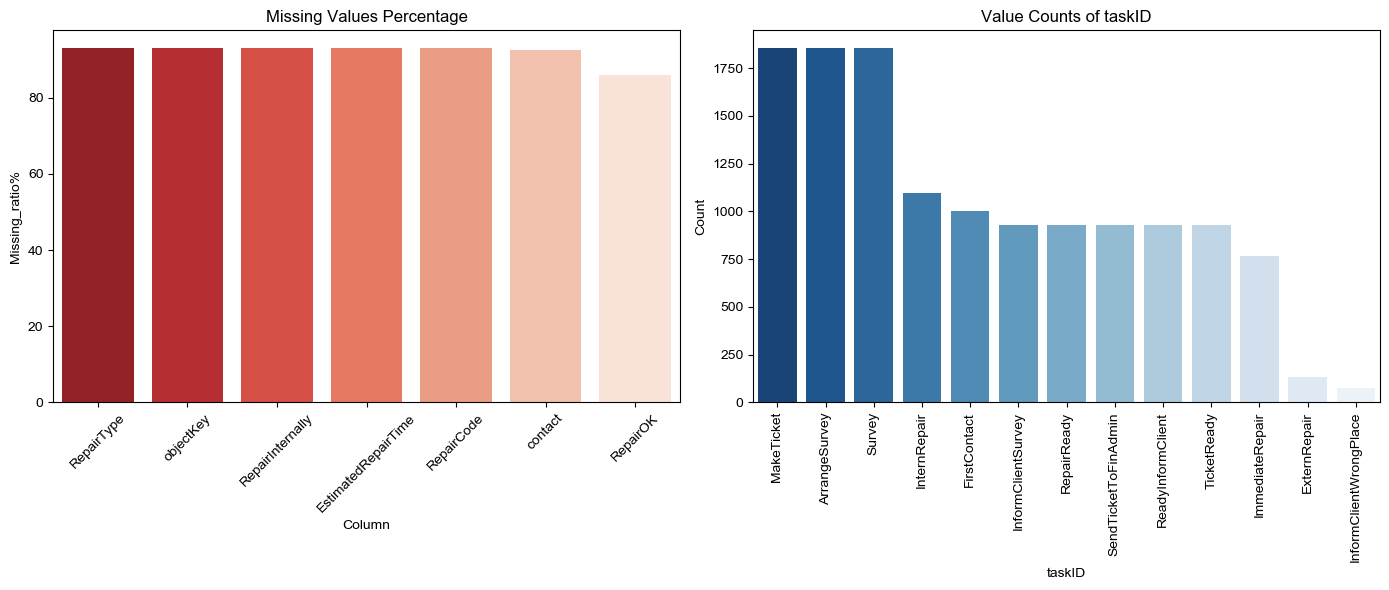

In [10]:
eda = basic_EDA()
eda.all_run(source, 'taskID') # 결측치 비율, taskID 빈도 분석

#### 2-2. 패턴 분석

- 가장 빈번하게 나타나는 업무 패턴 파악
- 전체적으로 업무가 어떻게 진행되는지, 어떤 패턴이 등장하는지 확인

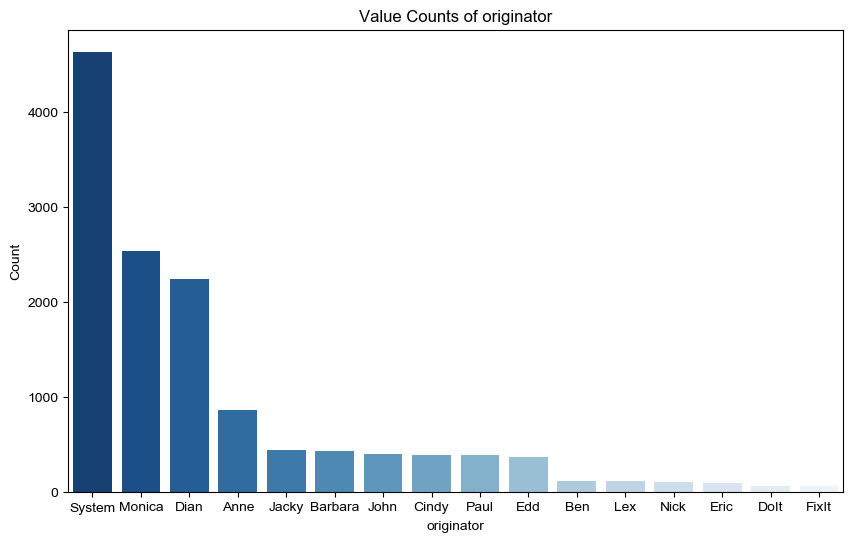

In [11]:
# 업무 담당자 빈도 분석
originator = eda.value_cnt(df=source, col='originator')
eda.bar_plot(originator, x_col='originator', y_col='Count')

- 이벤트 타입 분석

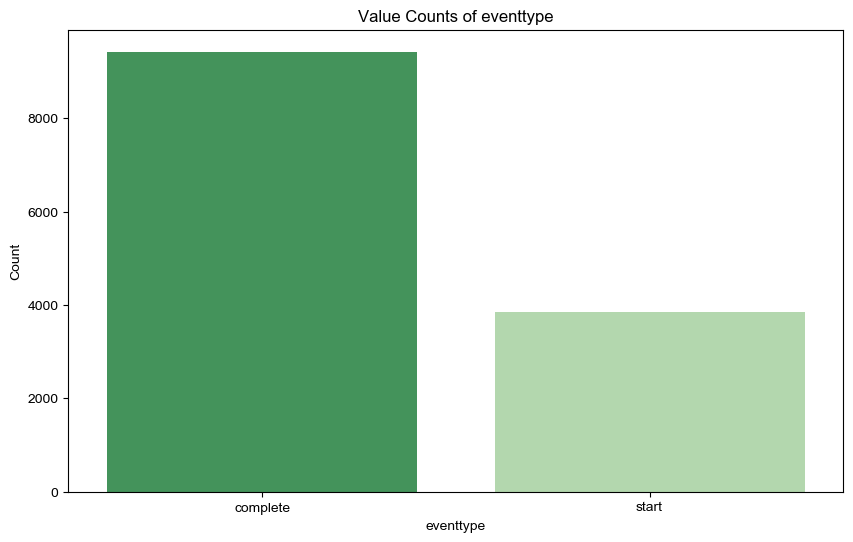

In [12]:
# 이벤트 타입
eventtype = eda.value_cnt(df=source, col='eventtype')
eda.bar_plot(eventtype, x_col='eventtype', y_col='Count', palette='Greens_r')

- Task 완료율 분석

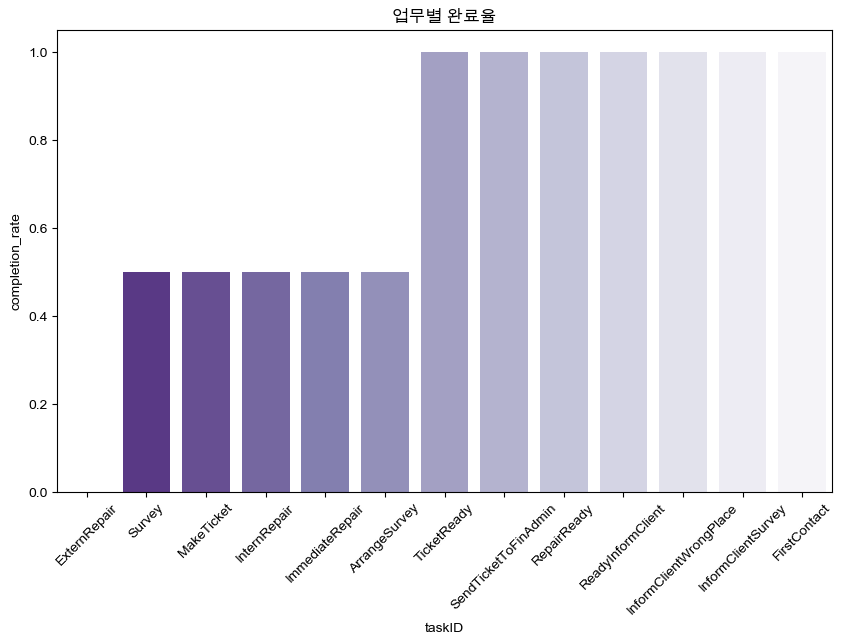

In [13]:
task_completion = source.groupby("taskID")["eventtype"].apply(lambda x: (x == "complete").mean()).reset_index()
task_completion.columns = ["taskID", "completion_rate"]
task_completion = task_completion.sort_values(by=['completion_rate', 'taskID'], ascending=[True, False]).reset_index(drop=True)

# 시각화
eda.bar_plot(df=task_completion, x_col="taskID", y_col="completion_rate",rotation=45,  palette="Purples_r", title='업무별 완료율')

#### 2-3. 소요 시간 분석

In [14]:
task_flow = source.groupby("caseID")["taskID"].apply(lambda x: list(dict.fromkeys(x))).reset_index()
task_flow_counts = task_flow["taskID"].value_counts().reset_index()
task_flow_counts.columns = ["Task_Sequence", "Count"]

pd.set_option('display.max_colwidth', None)
task_flow_counts

,Task_Sequence,Count
0,"[FirstContact, MakeTicket, ArrangeSurvey, InformClientSurvey, Survey, InternRepair, RepairReady, ReadyInformClient, SendTicketToFinAdmin, TicketReady]",237
1,"[FirstContact, MakeTicket, ArrangeSurvey, InformClientSurvey, Survey, InternRepair, RepairReady, SendTicketToFinAdmin, ReadyInformClient, TicketReady]",218
2,"[FirstContact, MakeTicket, ArrangeSurvey, InformClientSurvey, Survey, ImmediateRepair, RepairReady, SendTicketToFinAdmin, ReadyInformClient, TicketReady]",162
3,"[FirstContact, MakeTicket, ArrangeSurvey, InformClientSurvey, Survey, ImmediateRepair, RepairReady, ReadyInformClient, SendTicketToFinAdmin, TicketReady]",160
4,"[FirstContact, InformClientWrongPlace]",73
5,"[FirstContact, MakeTicket, ArrangeSurvey, InformClientSurvey, Survey, ExternRepair, RepairReady, SendTicketToFinAdmin, ReadyInformClient, TicketReady]",36
6,"[FirstContact, MakeTicket, ArrangeSurvey, InformClientSurvey, Survey, ExternRepair, RepairReady, ReadyInformClient, SendTicketToFinAdmin, TicketReady]",23
7,"[FirstContact, MakeTicket, ArrangeSurvey, InformClientSurvey, Survey, ImmediateRepair, ExternRepair, RepairReady, ReadyInformClient, SendTicketToFinAdmin, TicketReady]",21
8,"[FirstContact, MakeTicket, ArrangeSurvey, InformClientSurvey, Survey, ImmediateRepair, ExternRepair, RepairReady, SendTicketToFinAdmin, ReadyInformClient, TicketReady]",17
9,"[FirstContact, MakeTicket, ArrangeSurvey, InformClientSurvey, Survey, InternRepair, ExternRepair, RepairReady, ReadyInformClient, SendTicketToFinAdmin, TicketReady]",16


- 업무(Task)별 평균 소요 시간 분석

In [15]:
def format_timedelta(td):
    if pd.isnull(td):  # NaT 값 처리
        return "0시간 0분"
    seconds = td.total_seconds()
    days = int(seconds // 86400)
    hours = int((seconds % 86400) // 3600)
    minutes = int((seconds % 3600) // 60)
    if days > 0:
        return f"{days}일 {hours}시간 {minutes}분"
    return f"{hours}시간 {minutes}분"

In [16]:
source_copy = source.copy()
source_copy["timestamp"] = pd.to_datetime(source_copy["timestamp"])  # 시계열 변환

# 각 caseID 내에서 taskID별 시간 차이 계산
source_copy["prev_timestamp"] = source_copy.groupby("caseID")["timestamp"].shift(1)
source_copy["time_diff"] = source_copy["timestamp"] - source_copy["prev_timestamp"]
source_copy["time_diff"] = source_copy["time_diff"].fillna(pd.Timedelta(seconds=0))  # NaT를 0초로 채움
source_copy["time_diff_minute"] = source_copy["time_diff"].dt.total_seconds() / 60 # 분 단위

# 업무(Task)별 평균 소요 시간 분석
avg_time_per_task = source_copy.groupby("taskID")["time_diff"].mean().reset_index()
avg_time_per_task["소요 시간"] = avg_time_per_task["time_diff"].apply(format_timedelta)  # 보기 좋게 변환

# 최초 발생 시간 기준 정렬
task_order = source_copy.groupby("taskID")["timestamp"].min().reset_index()
task_order = task_order.sort_values("timestamp")

# 정렬하여 최종 결과 생성
avg_time_per_task = avg_time_per_task.merge(task_order[["taskID", "timestamp"]], on="taskID", how="left")
avg_time_per_task = avg_time_per_task.sort_values("timestamp").drop(columns=["timestamp", "time_diff"]).reset_index(drop=True)
source_copy.drop(columns=['time_diff'], inplace=True) # 제거

description = description.rename(columns={"Unnamed: 1": "의미", "task name": "taskID"})
mapped_df = avg_time_per_task.merge(description[["taskID", "의미"]], on="taskID", how="left")
mapped_df = mapped_df[['taskID', '의미', '소요 시간']]
mapped_df

,taskID,의미,소요 시간
0,FirstContact,최초 연락,0시간 0분
1,MakeTicket,청구서생성,0시간 2분
2,ArrangeSurvey,상담내용정의,1시간 0분
3,InformClientSurvey,고객문의전산처리,0시간 0분
4,Survey,상담진행,1일 14시간 43분
5,ExternRepair,외부업체 수리,0시간 0분
6,InternRepair,단순 수리,16시간 23분
7,ImmediateRepair,당업체 직접 수리,0시간 58분
8,RepairReady,수리종료,0시간 42분
9,InformClientWrongPlace,고객의 잘못된 정보,0시간 0분


- 담당자별 업무 처리 속도 분석

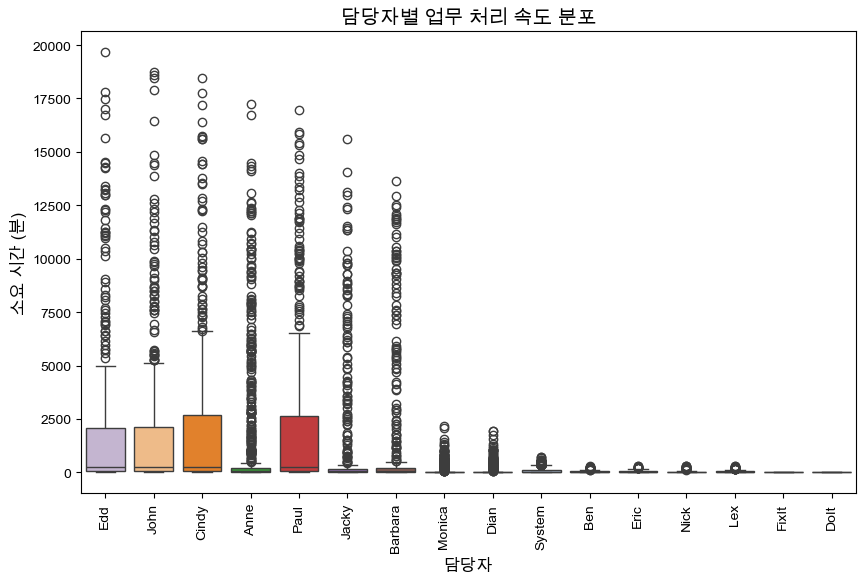

In [17]:
# 담당자별 색상 매핑
originators = source_copy["originator"].unique()
palette = dict(zip(originators, sns.color_palette("tab20", n_colors=len(originators))))

eda.box_plot(df=source_copy, x_col='originator', y_col='time_diff_minute', 
         title='담당자별 업무 처리 속도 분포', palette=palette, xlabel='담당자', ylabel='소요 시간 (분)')

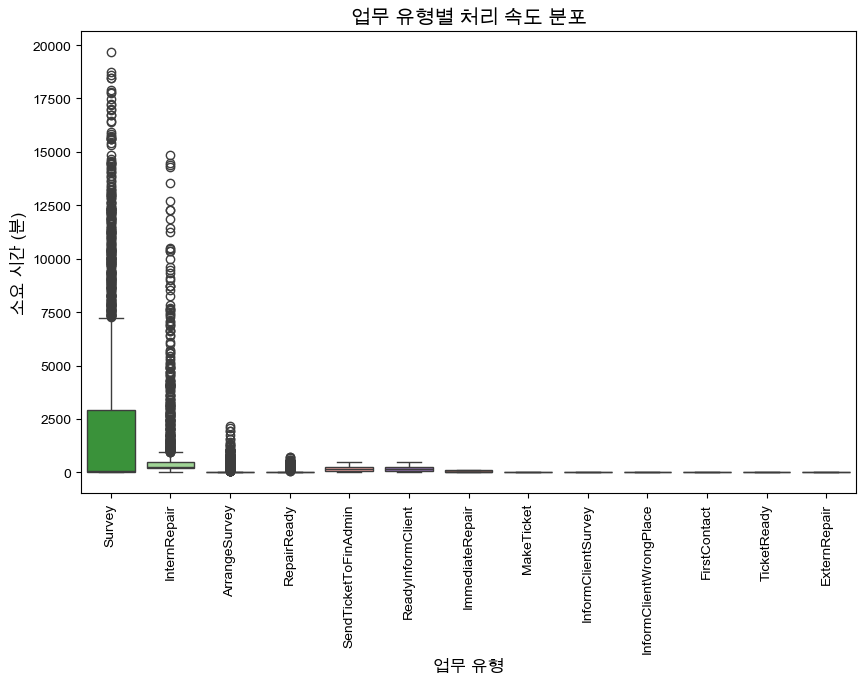

In [18]:
# 담당자별 색상 매핑
originators = source_copy["taskID"].unique()
palette = dict(zip(originators, sns.color_palette("tab20", n_colors=len(originators))))

eda.box_plot(df=source_copy, x_col='taskID', y_col='time_diff_minute', 
         title='업무 유형별 처리 속도 분포', palette=palette, xlabel='업무 유형', ylabel='소요 시간 (분)')

- 주요 업무(발생 빈도 평균 이상) 담당자별 평균 처리 속도 비교

In [19]:
# taskID 통계 확인
task_value = eda.value_cnt(source_copy, 'taskID')
task_value.describe()

,Count
count,13.000000
mean,1020.153846
std,569.038494
min,73.000000
25%,927.000000
50%,927.000000
75%,1094.000000
max,1854.000000


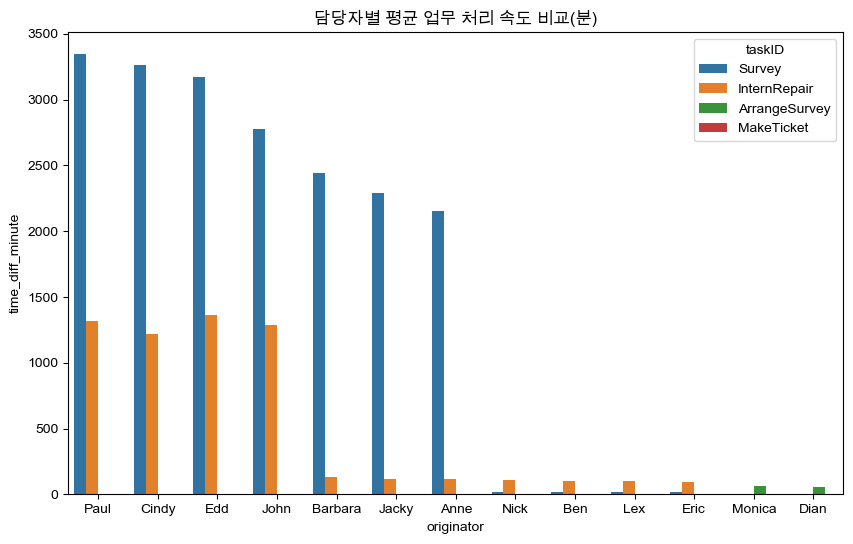

           taskID originator  time_diff_minute
25         Survey       Paul       3344.606383
18         Survey      Cindy       3264.473404
19         Survey        Edd       3170.450617
22         Survey       John       2776.960396
16         Survey    Barbara       2442.680180
21         Survey      Jacky       2287.136364
15         Survey       Anne       2156.238532
6    InternRepair        Edd       1366.766667
12   InternRepair       Paul       1315.005000
9    InternRepair       John       1286.340206
5    InternRepair      Cindy       1220.325000
3    InternRepair    Barbara        132.000000
2    InternRepair       Anne        119.483333
8    InternRepair      Jacky        119.441176
11   InternRepair       Nick        106.972222
4    InternRepair        Ben         99.547619
10   InternRepair        Lex         99.272727
7    InternRepair       Eric         96.931818
1   ArrangeSurvey     Monica         61.288639
0   ArrangeSurvey       Dian         59.134550
23         Su

In [20]:
mean_count = task_value["Count"].mean() # 평균
select_taskID = task_value[task_value["Count"] >= mean_count]["taskID"] # 평균 이하 제거
filter_source = source_copy[source_copy["taskID"].isin(select_taskID)]
task_originator_time = filter_source.groupby(["taskID", "originator"])["time_diff_minute"].mean().reset_index() # 담당자별 평균 처리 시간(분)
task_originator_time.sort_values(by=['time_diff_minute'], ascending=False, inplace=True)

# 시각화
eda.bar_plot(df=task_originator_time, x_col='originator', y_col='time_diff_minute', 
             palette='tab10', hue="taskID", title='담당자별 평균 업무 처리 속도 비교(분)')
print(task_originator_time)

### 2-4. 시간대별 업무 소요 시간 비교

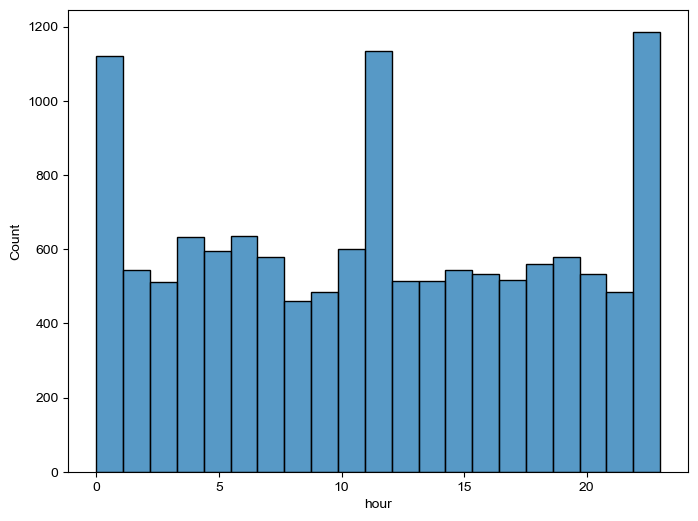

In [21]:
source_copy['hour'] = source_copy['timestamp'].dt.hour

plt.figure(figsize=(8, 6))
sns.histplot(source_copy['hour'])
plt.show()

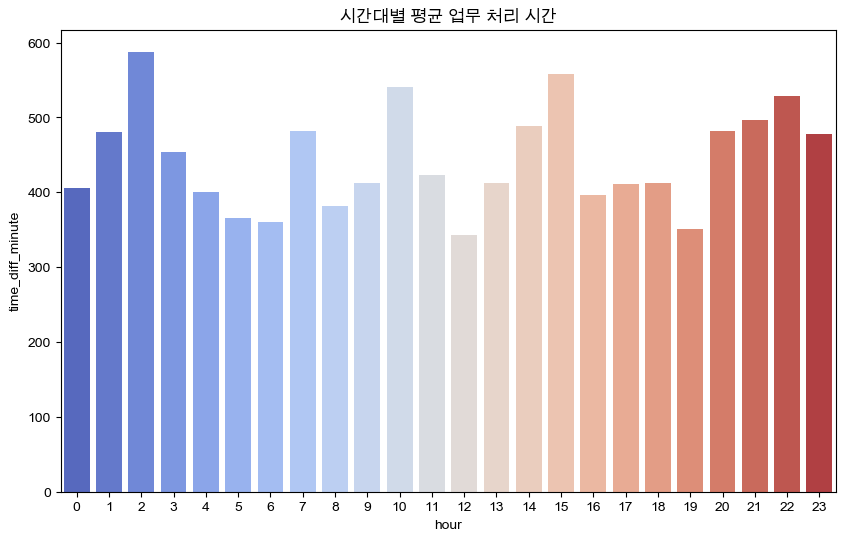

In [22]:
hourly_time_diff = source_copy.groupby("hour")["time_diff_minute"].mean().reset_index()
eda.bar_plot(hourly_time_diff, x_col='hour', y_col='time_diff_minute', title="시간대별 평균 업무 처리 시간", 
             palette=sns.color_palette("coolwarm", len(hourly_time_diff))) # 오전 / 오후 시간대별 색상 지정

### 2-5. 기존 업무 프로세스의 비효율성 분석 

In [23]:
# 이전 taskID를 추가하여 비교할 수 있도록 함
source_copy_sorted = source_copy.sort_values(by=["caseID", "timestamp"]).copy()
source_copy_sorted["prev_taskID"] = source_copy_sorted.groupby("caseID")["taskID"].shift(1)

# 동일한 caseID 내에서 동일한 taskID가 반복된 경우 필터링
repeated_tasks = source_copy_sorted[source_copy_sorted["taskID"] == source_copy_sorted["prev_taskID"]]

# 반복된 taskID의 빈도 확인
repeated_task_counts = repeated_tasks["taskID"].value_counts().reset_index()
repeated_task_counts.columns = ["taskID", "반복 횟수"]
repeated_task_counts

,taskID,반복 횟수
0,MakeTicket,927
1,ArrangeSurvey,927
2,Survey,927
3,InternRepair,586
4,ImmediateRepair,383


----------------------------

## 3.&nbsp; 문제 정의 (As - is)

1. 업무 빈도 문제 
    - 특정 업무(Task)의 발생 빈도가 매우 높음 (청구서 생성, 상담내용정의, 상담진행 이 전체 업무의 상당 부분 차지)
    - 특정 업무가 과도하게 많으면 배분 비효율성이 발생
    - 일부 업무는 빈도가 매우 낮음 (청구서 송달, 외부업체 수리, 고객문의전산처리)

2. 업무 담당자 간 불균형 문제
    - 일부 담당자(Monica, Dian, Anne)에게 업무가 과도하게 집중됨.
    - 시스템(자동화) 비율이 높긴하나 담당자별 업무 분배가 균등하지 않음

3. 업무별 완료율 문제
    - 업무(eventtype)에서 완료(complete) 비율이 높지만, 시작(start) 비율이 낮음.
    - 이는 실제 시작 기록이 누락되었거나, 시작과 완료 간의 이벤트 로깅 방식에 문제가 있을 가능성이 있음.
    - 특정 업무의 완료율이 매우 낮음(외부업체 수리, 상담진행, 청구서생성, 단순 수리, 당업체 직접 수리, 상담내용정의)
    - 완료율이 낮은 업무는 업무 프로세스에서 지연되거나 중단될 가능성이 큰걸로 보임

4. 업무 소요 시간 문제
    - 특정 업무(상담내용정의, 상담진행, 단순수리)의 평균 소요 시간이 지나치게 높음
    - 담당자별 업무 처리 속도에 극단적인 차이가 발생(Edd, John, Cindy, Anne, Paul, Jacky, Barbara)
    - 특히 Anne 담당자를 제외하고 나머지 담당자들은 업무 분배 빈도수가 적은걸로 나타났는데도 불구하고 업무 처리 속도가 매우 늦음
    - 담당자별 업무 유형별 처리 속도를 비교 분석한 결과 위 담당자들은 업무 처리 속도가 가장 많이 소요되는 업무들을 많이 맡고있어 속도가 느린걸로 나타남

5. 업무 프로세스 비효율성
    - 동일한 caseID 내에서 MakeTicket(청구서 생성), ArrangeSurvey(상담내용정의), Survey(상담진행) 등의 업무가 927번 반복되어 불필요한 업무 재수행 발생.
    - InternRepair(단순 수리), ImmediateRepair(당업체 직접 수리)도 반복 빈도가 높아 업무 효율성이 저하됨.

In [24]:
source_copy.head()

,caseID,taskID,originator,eventtype,timestamp,contact,RepairType,objectKey,RepairInternally,EstimatedRepairTime,RepairCode,RepairOK,prev_timestamp,time_diff_minute,hour
0,1,FirstContact,Dian,complete,1970-01-02 08:08:00,Phone,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0,8
1,1,MakeTicket,Dian,start,1970-01-02 08:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-02 08:08:00,0.0,8
2,1,MakeTicket,Dian,complete,1970-01-02 08:11:00,NaN,E,1340.0,NaN,NaN,NaN,NaN,1970-01-02 08:08:00,3.0,8
3,1,ArrangeSurvey,Dian,start,1970-01-02 08:11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-02 08:11:00,0.0,8
4,1,ArrangeSurvey,Dian,complete,1970-01-02 08:16:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-02 08:11:00,5.0,8


### 3-1. 가설 설정

- 가설 1: 특정 업무(Task)의 과도한 빈도가 업무 효율성을 저하시킨다.
- 가설 2: 업무 분배 불균형이 담당자별 업무 속도 차이를 유발한다.
- 가설 3: 특정 업무의 시작(start) 비율이 낮아 완료율 저하 문제를 유발한다.
- 가설 4: 특정 업무 및 특정 담당자가 업무 처리 속도를 저하시킨다.

### 3-2. 가설 검증

- 검증 1: 특정 업무가 전체 업무 중 차지하는 비율 확인, 업무 빈도와 소요 시간의 상관관계 분석 (피어슨 상관계수)
- 검증 2: 담당자별 평균 업무 소요 시간 분석(소요 시간이 증가하는지 확인), 담당자별 업무량과 평균 처리 시간 간 관계 분석(단순 회귀)
- 검증 3: 완료율이 낮은 업무들이 소요 시간이 비정상적으로 긴지 확인, 실제로 완료된 업무 중 시작 기록이 없는 데이터의 비율 계산
- 검증 4: ANOVA 검정을 사용해 업무 유형, 담당자별 속도 검증

업무 빈도와 평균 소요 시간 간 피어슨 상관계수: 0.443, p-value: 0.130


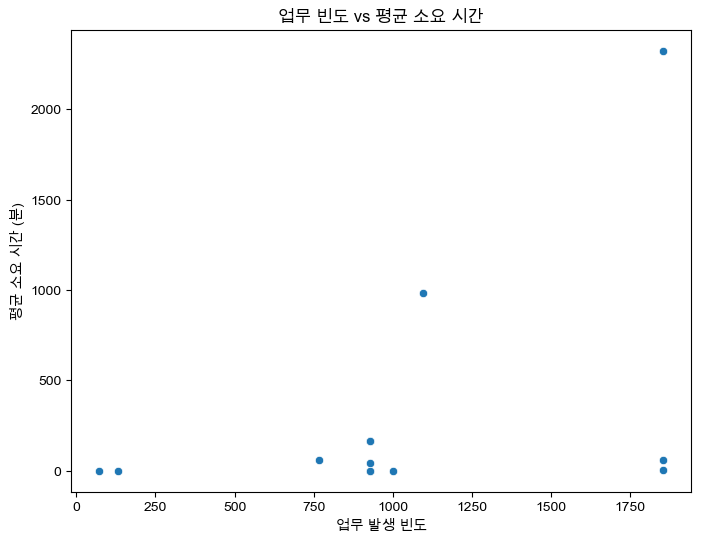

In [25]:
# 업무별 빈도 계산
task_counts = source_copy["taskID"].value_counts().reset_index()
task_counts.columns = ["taskID", "count"]

# 업무별 평균 소요 시간 계산
task_mean_time = source_copy.groupby("taskID")["time_diff_minute"].mean().reset_index()
task_analysis = pd.merge(task_counts, task_mean_time, on="taskID") # 병합

# 상관관계 분석 (피어슨 상관계수)
corr, p_value = pearsonr(task_analysis["count"], task_analysis["time_diff_minute"])
print(f"업무 빈도와 평균 소요 시간 간 피어슨 상관계수: {corr:.3f}, p-value: {p_value:.3f}")

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(data=task_analysis, x="count", y="time_diff_minute")
plt.title("업무 빈도 vs 평균 소요 시간")
plt.xlabel("업무 발생 빈도")
plt.ylabel("평균 소요 시간 (분)")
plt.show()

- 가설2: 검증

                            OLS Regression Results                            
Dep. Variable:       time_diff_minute   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.048
Method:                 Least Squares   F-statistic:                    0.3554
Date:                Tue, 25 Feb 2025   Prob (F-statistic):              0.561
Time:                        16:42:16   Log-Likelihood:                -123.52
No. Observations:                  15   AIC:                             251.0
Df Residuals:                      13   BIC:                             252.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        954.1912    319.952      2.982      0.0

/Users/mungughyeon/miniforge3/envs/ds_study/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


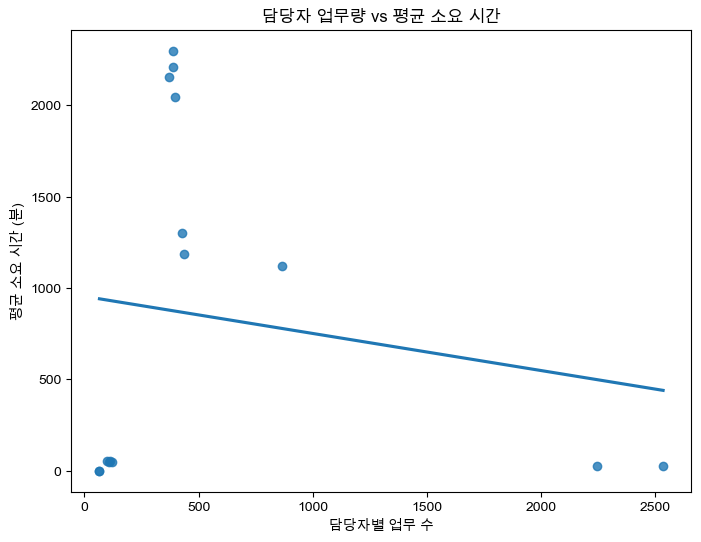

In [26]:
# 담당자별 업무량 계산
originator_task_count = (
    source_copy.groupby("originator")["taskID"]
    .count()
    .reset_index()
    .rename(columns={"taskID": "task_count"}))

# 'System'은 담당자가 아니므로 제외
originator_task_count = originator_task_count[originator_task_count["originator"] != "System"]

# 담당자별 평균 소요 시간 계산
originator_mean_time = source_copy.groupby("originator")["time_diff_minute"].mean().reset_index()
originator_analysis = pd.merge(originator_task_count, originator_mean_time, on="originator") # 병합

# 단순 회귀 분석 (업무 빈도 → 처리 시간 영향)
X = originator_analysis["task_count"]
y = originator_analysis["time_diff_minute"]
X = sm.add_constant(X)  # 절편 추가

model = sm.OLS(y, X).fit()
print(model.summary())

# 시각화
plt.figure(figsize=(8, 6))
sns.regplot(data=originator_analysis, x="task_count", y="time_diff_minute", ci=None)
plt.title("담당자 업무량 vs 평균 소요 시간")
plt.xlabel("담당자별 업무 수")
plt.ylabel("평균 소요 시간 (분)")
plt.show()

- 가설3: 검증

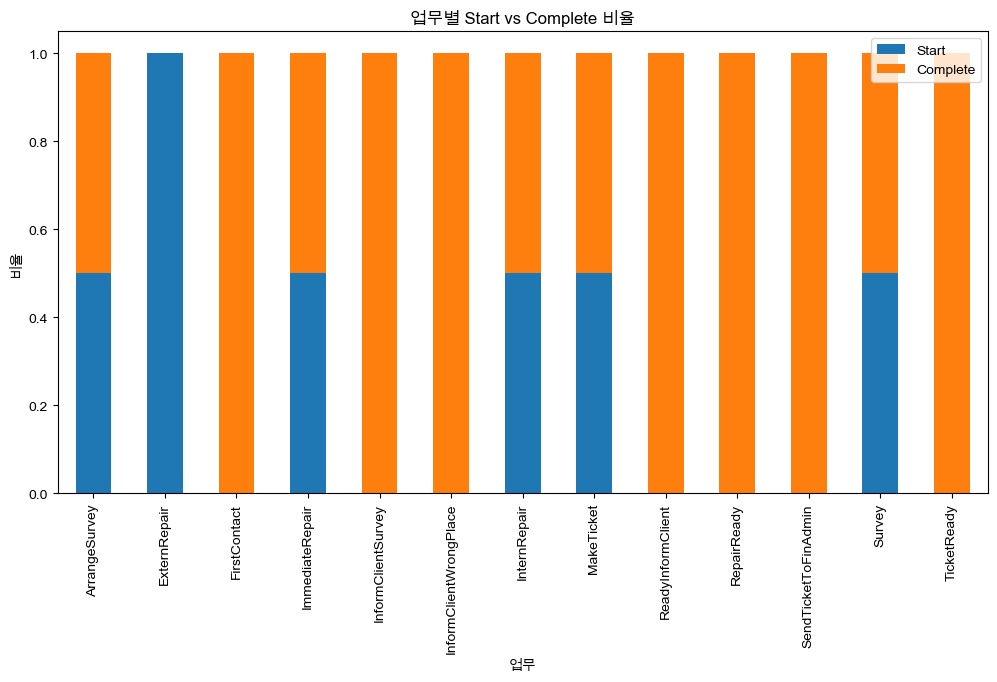

eventtype
complete    9419
start       3843
Name: count, dtype: int64
시작 기록이 없는 업무 비율: 53.85%


In [27]:
# 이벤트 타입별 빈도 확인
event_counts = source_copy["eventtype"].value_counts()

# 업무별 Start vs Complete 비율 계산
task_event_counts = source_copy.groupby(["taskID", "eventtype"]).size().unstack(fill_value=0)
task_event_counts["start_ratio"] = task_event_counts["start"] / (task_event_counts["start"] + task_event_counts["complete"])
task_event_counts["complete_ratio"] = task_event_counts["complete"] / (task_event_counts["start"] + task_event_counts["complete"])

# 시각화
task_event_counts[["start_ratio", "complete_ratio"]].plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("업무별 Start vs Complete 비율")
plt.xlabel("업무")
plt.ylabel("비율")
plt.legend(["Start", "Complete"])
plt.show()

print(event_counts)
missing_start_ratio = (task_event_counts["start"] == 0).sum() / len(task_event_counts) # 시작 기록이 누락된 업무 비율 계산
print(f"시작 기록이 없는 업무 비율: {missing_start_ratio:.2%}")

- 가설4: 검증

In [28]:
# 업무 유형별 소요 시간 ANOVA 검정
task_groups = [group["time_diff_minute"].dropna() for _, group in source_copy.groupby("taskID")]
anova_result_task = f_oneway(*task_groups)
print(f"업무 유형별 처리 속도 차이 ANOVA 결과: F-statistic={anova_result_task.statistic:.3f}, p-value={anova_result_task.pvalue:.3f}")

# 담당자별 처리 속도 ANOVA 검정
filtered_source = source_copy[source_copy["originator"] != "System"]  # System 제거
originator_groups = [group["time_diff_minute"].dropna() for _, group in filtered_source.groupby("originator")]
anova_result_originator = f_oneway(*originator_groups)
print(f"담당자별 처리 속도 차이 ANOVA 결과: F-statistic={anova_result_originator.statistic:.3f}, p-value={anova_result_originator.pvalue:.3f}")

업무 유형별 처리 속도 차이 ANOVA 결과: F-statistic=267.885, p-value=0.000
담당자별 처리 속도 차이 ANOVA 결과: F-statistic=104.797, p-value=0.000


### 3-3. 결과 요약

- 마지막 가설4의 검증 결과에서 업무 유형별, 담당자별 처리 속도 차이가 유의미한 결과가 나왔다.
- 이는 가설1, 2에 대한 검증 결과를 뒷받침하며, 단순히 업무량이 많다고 해서 담당자별 소요 시간이 많은 것이 아니라,
- 특정 업무 유형이 지나치게 많은 시간을 차지한다는 결론을 시사한다.
- 즉, 특정 유형의 업무가 평균 처리 시간을 증가시키고 있으며, 이 업무를 맡은 담당자들의 처리 속도가 상대적으로 느려지는 결과를 초래하고 있다.
-  업무 완료 데이터에서 시작 기록이 없는 업무 비율이 **약 54%**로 확인됨에 따라, 업무 진행 과정에서 기록 누락이 발생하고 있을 가능성이 높다.

----------------

## 4.&nbsp; 개선책(To - Be)

- 이전 EDA와 가설 검증 결과에서 특정 업무 유형의 과부하가 업무 지연을 초래하며,
- 특정 담당자들이 특정 유형의 업무를 과도하게 맡음으로 인해 처리 속도가 저하되는 문제가 확인되었다. 
- 또한, 업무 진행 과정에서 시작(Start) 기록이 누락된 비율이 54%로 상당히 높으며
- 기존 업무 프로세스를 분석한 결과, 특정 업무들이 동일한 caseID 내에서 반복 수행되는 현상을 확인,
- 이는 실제 업무 프로세스에서의 비효율성이 존재할 가능성이 높음을 나타낸다. 하여, 이를 해결하기 위한 개선책을 다음과 같이 제시


1. 업무 유형 조정 및 자동화 강화
    - 자동화 시스템 도입 → 반복적인 업무(상담내용정의, 상담진행, 청구서 생성, 등) 자동화 추진
    - ex: 챗봇, AI 음성지원 등

2. 업무 담당자 간 분배 최적화
    - 담당자별 업무 분배 균형 조정 → 업무 배정 시 처리 속도를 고려한 분배 시스템 도입

3. 업무 프로세스 개선 및 로깅 체계 강화
    - 초기 상담 이후 잘못된 정보로 인해 반복적인 업무 진행(MakeTicket → Survey → MakeTicket)을 줄이기 위해,
    - 고객 정보 검증 단계를 강화하거나 우선순위로 배치하여 재작업 발생을 방지
    - 업무 시작(Start) 기록 자동화 → 업무 시작 시 자동 기록 시스템 도입

4. 데이터 기반 의사결정 시스템 도입
    - 업무 유형별 처리 속도 및 담당자별 성과 분석

---------------

## 5. ERD 설계

In [35]:
from sqlalchemy import MetaData, Table, Column, Integer, String, ForeignKey, Float
from eralchemy2 import render_er

metadata = MetaData()

# Case 테이블 (각 업무 케이스 기본 정보)
case = Table('case', metadata,
    Column('caseID', Integer, primary_key=True),
    Column('FirstContact', String),
    Column('FirstContact_type', String),
    Column('FirstContact_originator', String)
)

# Task 테이블 (각 업무의 진행 과정)
task = Table('task', metadata,
    Column('taskID', Integer, primary_key=True),
    Column('caseID', Integer, ForeignKey('case.caseID')),
    Column('task_name', String),
    Column('task_start', String),
    Column('task_end', String),
    Column('task_originator', String)
)

# Repair 테이블 (수리 관련 정보)
repair = Table('repair', metadata,
    Column('repairID', Integer, primary_key=True),
    Column('caseID', Integer, ForeignKey('case.caseID')),
    Column('RepairType', String),
    Column('EstimatedRepairTime', Float),
    Column('RepairCode', String),
    Column('RepairOK', String)
)

# Event 테이블 (각 업무의 이벤트 정보)
event = Table('event', metadata,
    Column('eventID', Integer, primary_key=True),
    Column('taskID', Integer, ForeignKey('task.taskID')),
    Column('eventtype', String),  # start/complete 여부
    Column('timestamp', String),
    Column('originator', String)
)

# ERD 이미지 생성
render_er(metadata, 'ERD_diagram.png')

### ERD 이미지

<img src="../code/ERD_diagram.png" width=60%>